<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import modules 


In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Flatten, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

%run CapsNet.ipynb
from keras.utils import to_categorical as one_hot
from tqdm import tqdm
from time import clock

Using TensorFlow backend.


## Keras Model Parameters

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024    # Training size
valid_size  = 512     # Validation size
test_size   = 512     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [3]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

## Load Image Data
### Two classes of particles: electrons and photons 
### Images from 32x32 matrices of energies in each calorimeter cell (one cell = one pixel) 

In [4]:
img_rows, img_cols, nb_channels = 32, 32, 2     
nb_classes = 2 # Photon (0) or Electron (1)
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

## Configure Training/Validation/Test Sets

In [5]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

## Plot  sample of training images

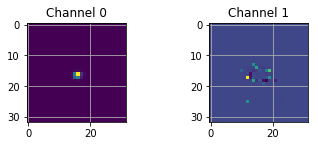

In [6]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1")  # Time
plt.grid(True)


plt.show()

### Shuffle Train Data

In [7]:
x_train_dict = {}
x_train_ids = []

for x in range(len(X_train)):
    x_train_dict[str(x)] = X_train[x,:,:]
    x_train_ids.append(x)
    
x_train_ids = np.array(x_train_ids)

x_train_ids = np.expand_dims(x_train_ids, axis = -1)
y_train = np.expand_dims(y_train, axis = -1)

train = np.concatenate([x_train_ids, y_train], axis = -1)
np.random.seed(1234)
np.random.shuffle(train)
print(train)

[[3.200e+02 0.000e+00]
 [1.448e+03 1.000e+00]
 [2.004e+03 1.000e+00]
 ...
 [1.318e+03 1.000e+00]
 [7.230e+02 0.000e+00]
 [8.150e+02 0.000e+00]]


### Shuffle Validation Data

In [8]:
x_val_dict = {}
x_val_ids = []

for x in range(len(X_valid)):
    x_val_dict[str(x)] = X_valid[x,:,:]
    x_val_ids.append(x)
    
x_val_ids = np.array(x_val_ids)

x_val_ids = np.expand_dims(x_val_ids, axis = -1)
y_valid = np.expand_dims(y_valid, axis = -1)

val = np.concatenate([x_val_ids, y_valid], axis = -1)
np.random.seed(1234)
np.random.shuffle(val)
print(val)

[[836.   1.]
 [523.   1.]
 [ 89.   0.]
 ...
 [294.   0.]
 [723.   1.]
 [815.   1.]]


## Define CNN Model

In [9]:
### Define CNN Model ###

model, eval_model = CAPSNET((img_rows, img_cols, nb_channels), nb_classes)

Instructions for updating:
Colocations handled automatically by placer.


### Train the Model

In [10]:
history = []
best_val_acc = 0.0
for epoch in range(epochs):
    print("Epoch %d" % (epoch + 1))

    # Fit training data
    print('Fit training data')
    train_status = []
    train_time = 0.0
        
    for i in tqdm(range(len(train))):
        x = x_train_dict[str(int(train[i, 0]))]
        x = np.expand_dims(x, axis = 0)
        y = one_hot(train[i,1], num_classes = nb_classes)
        y = y.reshape((1,2))
        train_start_time = clock()
        output = model.train_on_batch([x, y], [y])
        #output = model.train_on_batch([x, y], [y, x])
        train_time += clock() - train_start_time            
        train_status.append(output)

    # Calculate training loss and accuracy
    train_status = np.array(train_status)
         
    train_loss = np.average(train_status[:, 0])
    train_acc = np.average(train_status[:, 1])
    print('Train Loss ->', train_loss)
    print('Train Accu ->', train_acc)
    print('Train Time ->', train_time, '\n')
    
    # Test on validation data
    print('Testing on Validation Data')
    val_status = []
    val_time = 0.0
    for i in tqdm(range(len(val))):
        x = x_val_dict[str(int(val[i, 0]))]
        x = np.expand_dims(x, axis = 0)
        y = one_hot(val[i,1], num_classes = nb_classes)
        y = y.reshape((1,2))
         
        val_start_time = clock()
        output = model.test_on_batch([x, y], [y])
        #output = model.test_on_batch([x, y], [y, x])
        val_time += clock() - val_start_time
            
        val_status.append(output)

    # Calculate validation loss and accuracy
    val_status = np.array(val_status)
        
    val_loss = np.average(val_status[:, 0])
    val_acc = np.average(val_status[:, 1])
    print('Val Loss ->', val_loss)
    print('Val Accu ->', val_acc)
    print('Val Time ->', val_time, '\n')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        
        print('Saving Model Weights')
        model.save_weights('Particles' + '_best_acc_loss_weights.hdf5')

    history.append([(epoch + 1), train_loss, train_acc, train_time, val_loss, val_acc, val_time])

    # if train_acc == 1:
    #     print("Stopping early")
    #     break

  0%|          | 0/2048 [00:00<?, ?it/s]

Epoch 1
Fit training data
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


  0%|          | 1/1024 [00:00<01:42,  9.96it/s]

Train Loss -> 1.0002891
Train Accu -> 0.5078125
Train Time -> 712.7286429999979 

Testing on Validation Data


  0%|          | 0/2048 [00:00<?, ?it/s]

Val Loss -> 0.9952588
Val Accu -> 0.50878906
Val Time -> 22.431491999999935 

Saving Model Weights
Epoch 2
Fit training data


  2%|▏         | 20/1024 [00:00<00:05, 194.14it/s]

Train Loss -> 0.98563755
Train Accu -> 0.5263672
Train Time -> 722.796477999993 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:54, 17.79it/s]

Val Loss -> 0.97662354
Val Accu -> 0.5283203
Val Time -> 19.58468300000004 

Saving Model Weights
Epoch 3
Fit training data


  3%|▎         | 26/1024 [00:00<00:03, 250.89it/s]

Train Loss -> 0.9441471
Train Accu -> 0.54833984
Train Time -> 709.5086660000059 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:01, 16.83it/s]

Val Loss -> 0.9244502
Val Accu -> 0.56347656
Val Time -> 17.158414999992146 

Saving Model Weights
Epoch 4
Fit training data


  2%|▏         | 22/1024 [00:00<00:04, 218.40it/s]

Train Loss -> 0.9526044
Train Accu -> 0.5463867
Train Time -> 730.1619840000094 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:01, 16.79it/s]

Val Loss -> 0.91943616
Val Accu -> 0.5751953
Val Time -> 28.23248399999784 

Saving Model Weights
Epoch 5
Fit training data


  3%|▎         | 26/1024 [00:00<00:03, 251.64it/s]

Train Loss -> 0.9330814
Train Accu -> 0.5703125
Train Time -> 725.5746860000231 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:09, 15.81it/s]

Val Loss -> 0.9958793
Val Accu -> 0.5341797
Val Time -> 20.46510099999705 

Epoch 6
Fit training data


  2%|▏         | 23/1024 [00:00<00:04, 221.68it/s]

Train Loss -> 0.98364794
Train Accu -> 0.55126953
Train Time -> 707.418124999997 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:47, 19.12it/s]

Val Loss -> 0.9963659
Val Accu -> 0.5048828
Val Time -> 20.15507300000172 

Epoch 7
Fit training data


  2%|▏         | 22/1024 [00:00<00:04, 215.44it/s]

Train Loss -> 0.95787203
Train Accu -> 0.5654297
Train Time -> 713.6019290000031 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:29, 13.66it/s]

Val Loss -> 0.9281328
Val Accu -> 0.59375
Val Time -> 20.09828200001175 

Saving Model Weights
Epoch 8
Fit training data


  2%|▏         | 23/1024 [00:00<00:04, 226.75it/s]

Train Loss -> 0.90186036
Train Accu -> 0.5908203
Train Time -> 730.4887419999868 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:56, 17.55it/s]

Val Loss -> 0.89389443
Val Accu -> 0.58691406
Val Time -> 22.094612999983838 

Epoch 9
Fit training data


  2%|▏         | 22/1024 [00:00<00:04, 213.19it/s]

Train Loss -> 0.9249988
Train Accu -> 0.58251953
Train Time -> 720.213227999996 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:07, 16.10it/s]

Val Loss -> 0.8881678
Val Accu -> 0.58691406
Val Time -> 30.258970000012596 

Epoch 10
Fit training data


  2%|▏         | 21/1024 [00:00<00:04, 206.12it/s]

Train Loss -> 0.87160265
Train Accu -> 0.61083984
Train Time -> 723.6220350000094 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:55, 17.72it/s]

Val Loss -> 0.88384825
Val Accu -> 0.6044922
Val Time -> 18.873261000020648 

Saving Model Weights
Epoch 11
Fit training data


  2%|▏         | 16/1024 [00:00<00:06, 148.83it/s]

Train Loss -> 0.874254
Train Accu -> 0.60498047
Train Time -> 746.2905929999906 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:54, 17.87it/s]

Val Loss -> 0.89037573
Val Accu -> 0.5957031
Val Time -> 17.52569500003483 

Epoch 12
Fit training data


  2%|▏         | 19/1024 [00:00<00:05, 189.56it/s]

Train Loss -> 0.84809756
Train Accu -> 0.64160156
Train Time -> 744.1959119999283 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:55, 11.67it/s]

Val Loss -> 0.88940763
Val Accu -> 0.5966797
Val Time -> 17.339890999983254 

Epoch 13
Fit training data


  2%|▏         | 17/1024 [00:00<00:05, 168.60it/s]

Train Loss -> 0.8420112
Train Accu -> 0.63964844
Train Time -> 739.6845049999756 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:57, 17.46it/s]

Val Loss -> 0.89051044
Val Accu -> 0.59472656
Val Time -> 17.667938000013237 

Epoch 14
Fit training data


  2%|▏         | 24/1024 [00:00<00:04, 233.35it/s]

Train Loss -> 0.79986465
Train Accu -> 0.6586914
Train Time -> 725.1124980000131 

Testing on Validation Data


  0%|          | 0/2048 [00:00<?, ?it/s]

Val Loss -> 0.8905244
Val Accu -> 0.6142578
Val Time -> 17.567582999981823 

Saving Model Weights
Epoch 15
Fit training data


  2%|▏         | 21/1024 [00:00<00:04, 206.57it/s]

Train Loss -> 0.78138924
Train Accu -> 0.6870117
Train Time -> 702.5124720000313 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:47, 19.06it/s]

Val Loss -> 0.90871644
Val Accu -> 0.58496094
Val Time -> 20.95038600002772 

Epoch 16
Fit training data


  2%|▏         | 23/1024 [00:00<00:04, 229.78it/s]

Train Loss -> 0.7686471
Train Accu -> 0.6923828
Train Time -> 741.9571809999725 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:57, 17.43it/s]

Val Loss -> 0.9021847
Val Accu -> 0.5957031
Val Time -> 18.20627599999716 

Epoch 17
Fit training data


  2%|▏         | 23/1024 [00:00<00:04, 222.00it/s]

Train Loss -> 0.76499695
Train Accu -> 0.69140625
Train Time -> 739.6507220000167 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:55, 17.70it/s]

Val Loss -> 0.89622
Val Accu -> 0.5966797
Val Time -> 18.25021199998264 

Epoch 18
Fit training data


  2%|▏         | 21/1024 [00:00<00:04, 203.66it/s]

Train Loss -> 0.74783427
Train Accu -> 0.7138672
Train Time -> 734.6299150000432 

Testing on Validation Data


  0%|          | 2/2048 [00:00<02:04, 16.49it/s]

Val Loss -> 0.92114526
Val Accu -> 0.6064453
Val Time -> 18.194179000021904 

Epoch 19
Fit training data


  2%|▏         | 22/1024 [00:00<00:04, 219.10it/s]

Train Loss -> 0.79753625
Train Accu -> 0.6713867
Train Time -> 737.5940999999439 

Testing on Validation Data


  0%|          | 2/2048 [00:00<01:59, 17.10it/s]

Val Loss -> 0.9999323
Val Accu -> 0.54296875
Val Time -> 18.22002400000565 

Epoch 20
Fit training data


  2%|▏         | 19/1024 [00:00<00:05, 187.73it/s]

Train Loss -> 0.8844737
Train Accu -> 0.63183594
Train Time -> 737.9544440000063 

Testing on Validation Data


100%|██████████| 1024/1024 [00:08<00:00, 114.73it/s]

Val Loss -> 0.938833
Val Accu -> 0.5859375
Val Time -> 35.51903899998797 



### Shuffle test data

In [11]:
x_test_dict = {}
x_test_ids = []

for x in range(len(X_test)):
    x_test_dict[str(x)] = X_test[x,:,:]
    x_test_ids.append(x)
    
x_test_ids = np.array(x_test_ids)

x_test_ids = np.expand_dims(x_test_ids, axis = -1)
y_test = np.expand_dims(y_test, axis = -1)
print(y_test.shape)
print(x_test_ids.shape)
test = np.concatenate([x_test_ids, y_test], axis = -1)
np.random.seed(1234)
np.random.shuffle(test)
print(test)

(1024, 1)
(1024, 1)
[[836.   1.]
 [523.   1.]
 [ 89.   0.]
 ...
 [294.   0.]
 [723.   1.]
 [815.   1.]]


In [16]:
# Load weights of best model
eval_model.load_weights('Particles' + '_best_acc_loss_weights.hdf5')
eval_model.compile(optimizer=RMSprop(lr = 0.001, rho = 0.9, epsilon = None, decay = 0.0), loss=categorical_hinge, metrics={'capsnet': 'accuracy'})

# Evaluate test data
print('Evaluating Test Data')
test_status = []
test_time = 0.0

for i in tqdm(range(len(test))):
    x = x_test_dict[str(int(test[i, 0]))]
    x = np.expand_dims(x, axis = 0)
    y = one_hot(test[i,1], num_classes = nb_classes)
    y = y.reshape((1,2))
    
    test_start_time = clock()
    output = model.test_on_batch([x, y], [y])
    #output = model.train_on_batch([x, y], [y, x])
    test_time += clock() - test_start_time            
    test_status.append(output)

# Calculate test loss and accuracy
test_status = np.array(test_status)

test_loss = np.average(test_status[:, 0])
test_acc = np.average(test_status[:, 1])
print('Test Loss ->', test_loss)
print('Test Accu ->', test_acc)
print('Test Time ->', test_time, '\n')

# Save training history to csv file
history = np.array(history)
test_footer = 'Test [loss accu time], %f, %f, %f' % (test_loss, test_acc, test_time)
    
np.savetxt(
    'Particles' + '_metrics.csv',
    history,
    fmt = '%1.3f',
    delimiter = ', ',
    header = 'epoch, train_loss, train_acc, train_time, val_loss, val_acc, val_time',
    footer = test_footer
)

  0%|          | 1/1024 [00:00<02:50,  5.99it/s]

Evaluating Test Data


100%|██████████| 1024/1024 [00:05<00:00, 188.80it/s]

Test Loss -> 0.8992946
Test Accu -> 0.6113281
Test Time -> 21.19481299997824 



### Evaluate The Model

In [37]:
# Evaluate on validation set
y = one_hot(test[:,1], num_classes = nb_classes)

x_eval = []
for x in range(len(test)):
    x_eval.append(x_test_dict[str(int(test[x,0]))])

x_eval = np.array(x_eval)

'''
score = model.evaluate([x_eval, y], y, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict([X_valid, y])
y_p = np.array([[np.amax(i)] for i in y_pred])
print(y_p)
fpr, tpr, _ = roc_curve(y_valid, y_p)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)
'''
# Evaluate on test set
score = model.evaluate([x_eval, y], y, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict([x_eval, y])

for p in y_pred:
    if np.argmax(p) == 0:
        p[0] = 1.0
        p[1] = 0.0
    else:
        p[0] = 0.0
        p[1] = 1.0
y_p = np.array([[np.argmax(i)] for i in y_pred])
y_t = np.array([[np.argmax(i)] for i in y])

fpr, tpr, _ = roc_curve(y_t, y_p)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

1024/1024 [==============================] - 2s 2ms/step

Test loss / accuracy: 0.8993 / 0.6113
[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]
[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]
Test ROC AUC: 0.611328125


No handles with labels found to put in legend.


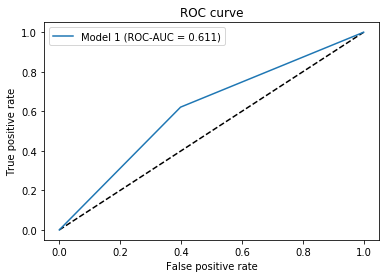

In [38]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()